# YouTube Dislikes predictions

This notebook contains code to:
- transform initial dataset using TextVectorization
- create pretrained Embedding layers
- train a neural network to predict the number of dislikes

## Imports

In [1]:
import pickle

In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.utils import plot_model

## Load data saved in `data_trasformations` notebook

In [4]:
y_train = np.load('models/data/y_train.npy')
y_test = np.load('models/data/y_test.npy')

numeric_data_train = np.load('models/data/numeric_data_train.npy')
numeric_data_test = np.load('models/data/numeric_data_test.npy')

In [5]:
author_text_data_train = pickle.load(open("models/data/author_text_data_train.p", "rb"))
author_text_data_test = pickle.load(open("models/data/author_text_data_test.p", "rb"))

comments_data_train = pickle.load(open("models/data/comments_data_train.p", "rb"))
comments_data_test = pickle.load(open("models/data/comments_data_test.p", "rb"))

In [6]:
embeddings_1 = pickle.load(open("models/data/embeddings_1.p", "rb"))
embeddings_2 = pickle.load(open("models/data/embeddings_2.p", "rb"))

## Helper functions

# Model

## Model architecture

In [7]:
def fully_connected(verbose=False):
    
    # 3 vectors of numbers
    numbers_input = keras.Input(shape=(3,), name="numbers_input")

    # Final part of the model
    dense_1 = layers.Dense(32, activation='relu', name='dense_32_units_1')(numbers_input)
    dropout_1 = layers.Dropout(0.1, name="dropout_1")(dense_1)
    dense_2 = layers.Dense(32, activation='relu', name='dense_32_units_2')(dropout_1)
    dropout_2 = layers.Dropout(0.1, name="dropout_2")(dense_2)
    dense_3 = layers.Dense(16, activation='relu', name='dense_16_units')(dropout_2)
    dropout_3 = layers.Dropout(0.1, name="dropout_3")(dense_3)
    output = layers.Dense(1, activation='relu', name='output')(dropout_3)


    model = keras.Model(inputs=numbers_input,
                        outputs=output,
                        name="dislikes_predictor")
    if verbose:
        # summarize layers
        print(model.summary())
        # plot model architecture
        plot_model(model, show_shapes=True)
                   # to_file='article/img/network_architecture.png')
            
    return model

In [8]:
model = fully_connected(verbose=True)

Model: "dislikes_predictor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 numbers_input (InputLayer)  [(None, 3)]               0         
                                                                 
 dense_32_units_1 (Dense)    (None, 32)                128       
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_32_units_2 (Dense)    (None, 32)                1056      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_16_units (Dense)      (None, 16)                528       
                                                                 
 dropout_3 (Dropout)         (None, 16)         

In [9]:
model_name_to_save = 'fully_connected'

In [10]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.MeanAbsoluteError(),
    metrics=['accuracy']
)

In [12]:
# ModelCheckpoint to save model in case of interrupting the learning process
checkpoint = keras.callbacks.ModelCheckpoint(
    f"models/{model_name_to_save}.h5",
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    verbose=1)

callbacks = [checkpoint]

history = model.fit(numeric_data_train,
                    y_train,
                    epochs=10,
                    batch_size=64,
                    validation_split=0.2,
                   callbacks=callbacks)

model.save(f"models/{model_name_to_save}.h5")

Epoch 1/10
127/186 [===================>..........] - ETA: 0s - loss: 9569.8594 - accuracy: 0.0000e+00 
Epoch 00001: val_loss improved from inf to 6200.09326, saving model to models\fully_connected.h5
186/186 [==============================] - 1s 2ms/step - loss: 8431.0371 - accuracy: 0.0000e+00 - val_loss: 6200.0933 - val_accuracy: 0.0000e+00
Epoch 2/10
133/186 [====================>.........] - ETA: 0s - loss: 6319.0664 - accuracy: 0.0000e+00
Epoch 00002: val_loss did not improve from 6200.09326
186/186 [==============================] - 0s 954us/step - loss: 6383.9360 - accuracy: 0.0000e+00 - val_loss: 6200.0933 - val_accuracy: 0.0000e+00
Epoch 3/10
134/186 [====================>.........] - ETA: 0s - loss: 6361.0591 - accuracy: 0.0000e+00
Epoch 00003: val_loss did not improve from 6200.09326
186/186 [==============================] - 0s 939us/step - loss: 6390.7393 - accuracy: 0.0000e+00 - val_loss: 6200.0933 - val_accuracy: 0.0000e+00
Epoch 4/10
133/186 [====================>.....

Model: "dislikes_predictor"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 author_text_input (InputLayer)  [(None, None)]      0           []                               
                                                                                                  
 comments_input (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 pretrained_embeddings_for_auth  (None, None, 50)    1000100     ['author_text_input[0][0]']      
 or_text (Embedding)                                                                              
                                                                                                  
 pretrained_embeddings_for_comm  (None, None, 50)    1000100     ['comments_input

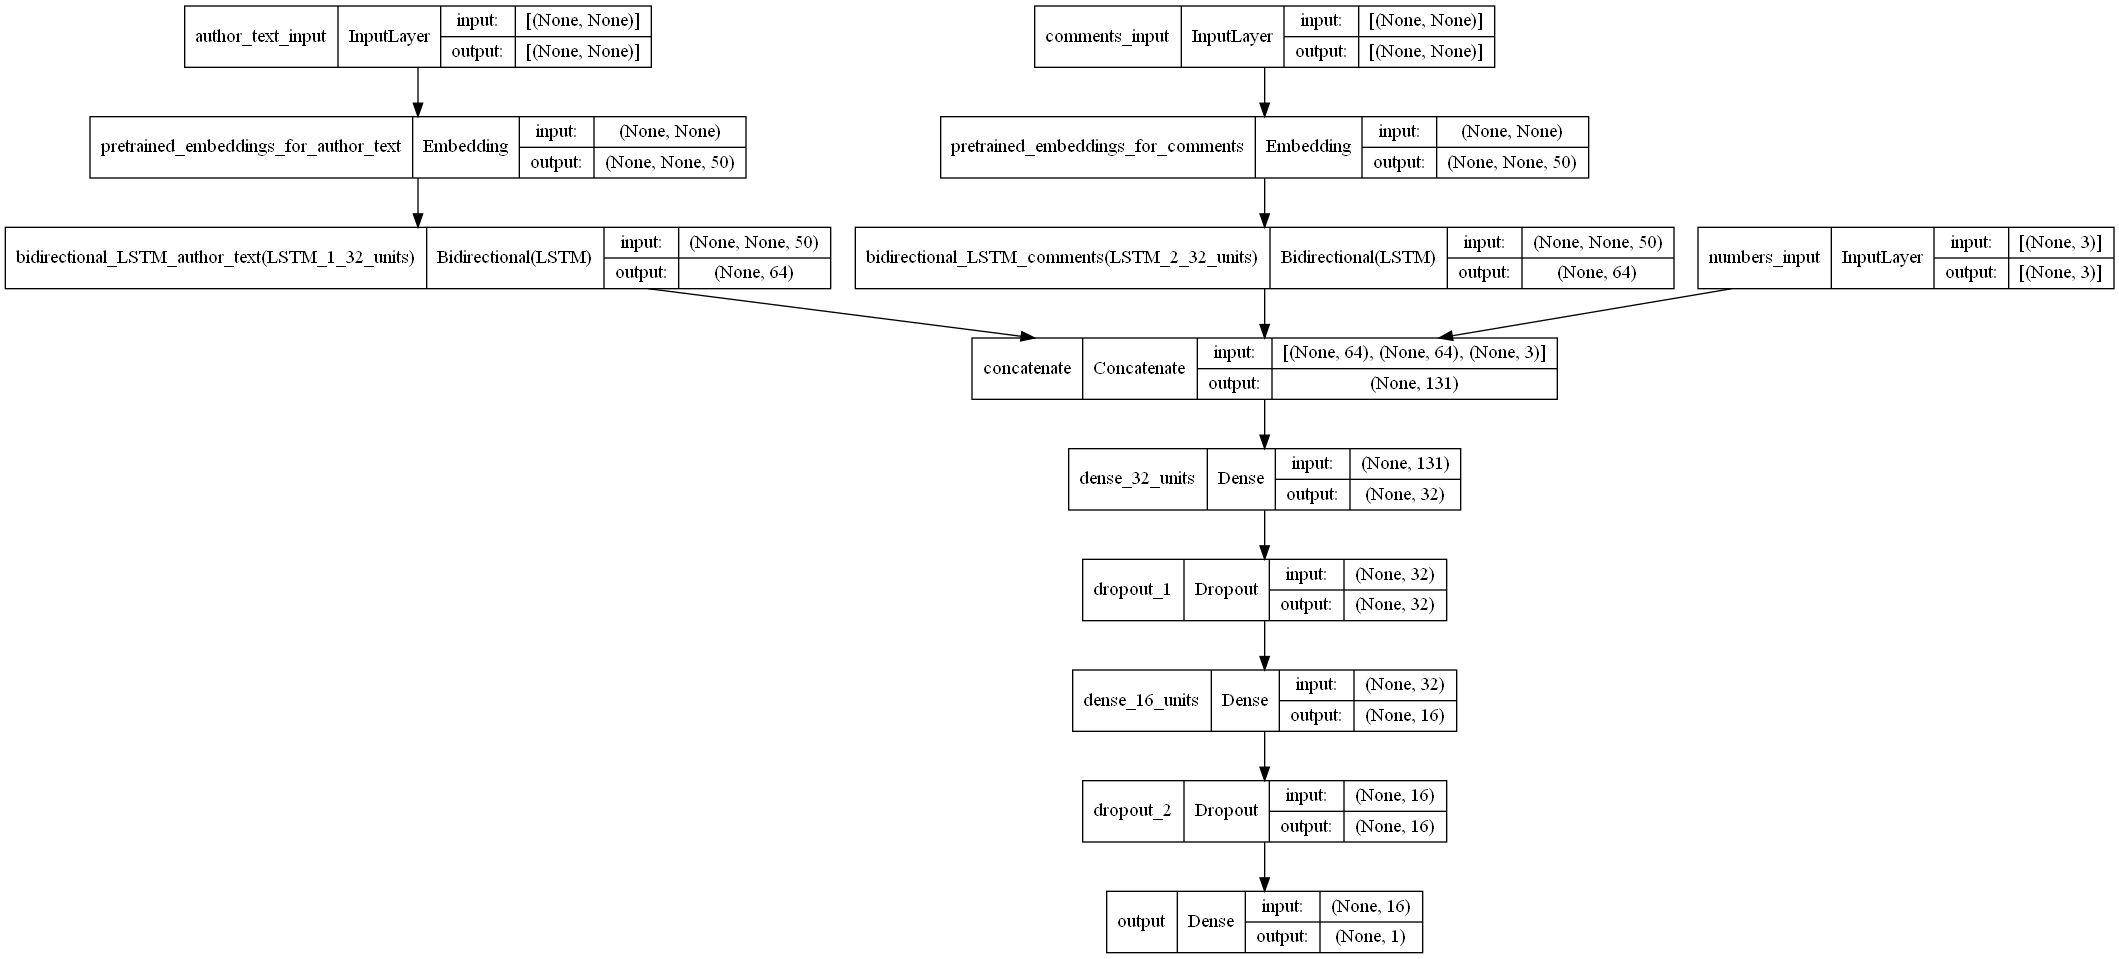

In [13]:
# Variable-length sequence of ints
text_1_input = keras.Input(shape=(None,), name="author_text_input")

# Variable-length sequence of ints
text_2_input = keras.Input(shape=(None,), name="comments_input")

# 3 vectors of numbers
numbers_input = keras.Input(shape=(3,), name="numbers_input")

# Embed each word into a 50-dimensional vector using pretrained GloVe embeddings
text_1_features = embeddings_1(text_1_input)
text_2_features = embeddings_2(text_2_input)

# Reduce sequence of embedded words in the title into a single 128-dimensional vector
# uncomment for 2-layers LSTM

# text_1_features = layers.Bidirectional(layers.LSTM(32, return_sequences=True))(text_1_features)
text_1_features = layers.Bidirectional(layers.LSTM(
    32, name="LSTM_1_32_units"), name="bidirectional_LSTM_author_text")(text_1_features)
# text_2_features = layers.Bidirectional(layers.LSTM(32, return_sequences=True))(text_2_features)
text_2_features = layers.Bidirectional(layers.LSTM(
    32, name="LSTM_2_32_units"), name="bidirectional_LSTM_comments")(text_2_features)

# Merge all available features into a single large vector via concatenation
concat = layers.concatenate(
    [text_1_features, text_2_features, numbers_input], name='concatenate')

# Final part of the model
dense_1 = layers.Dense(32, activation='relu', name='dense_32_units')(concat)
dropout_1 = layers.Dropout(0.3, name="dropout_1")(dense_1)
dense_2 = layers.Dense(16, activation='relu', name='dense_16_units')(dropout_1)
dropout_2 = layers.Dropout(0.3, name="dropout_2")(dense_2)
output = layers.Dense(1, activation='relu', name='output')(dropout_2)


model = keras.Model(inputs=[text_1_input, text_2_input, numbers_input],
                    outputs=output,
                    name="dislikes_predictor")

# summarize layers
print(model.summary())
# plot model architecture
plot_model(model, show_shapes=True,
           to_file='article/img/network_architecture.png')

## Compile and train a model

In [15]:
# X_train in a form understandable to the network
train_data = {"author_text_input": author_text_data_train,
              "comments_input": author_text_data_train,
              "numbers_input": numeric_data_train}

In [16]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.MeanSquaredError(),
    metrics=['accuracy']
)

In [17]:
model_name_to_save = 'model_5_epoch'

In [18]:
# ModelCheckpoint to save model in case of interrupting the learning process
checkpoint = keras.callbacks.ModelCheckpoint(
    f"models/{model_name_to_save}.h5",
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    verbose=1)

callbacks = [checkpoint]

In [19]:
history = model.fit(train_data,
                    y_train,
                    epochs=1,
                    batch_size=32,
                    callbacks=callbacks,
                    validation_split=0.2)

model.save(f"models/{model_name_to_save}.h5")

371/371 [==============================] - ETA: 0s - loss: 261827035136.0000 - accuracy: 0.0000e+00
Epoch 00001: val_loss improved from inf to 1260867712.00000, saving model to models\model_5_epoch.h5
371/371 [==============================] - 281s 743ms/step - loss: 261827035136.0000 - accuracy: 0.0000e+00 - val_loss: 1260867712.0000 - val_accuracy: 0.0000e+00


In [20]:
import matplotlib.pyplot as plt

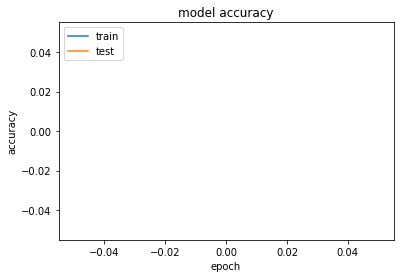

In [21]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

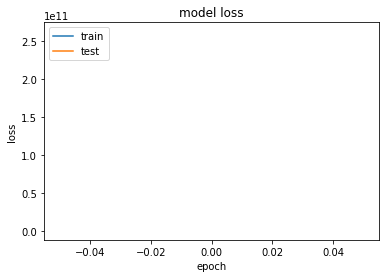

In [22]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()